## Brain MRI Tumor Detection - Functional CNN with PyTorch

##### Chindea Cosmin, Codreanu Alexandru, Boanc Ionut

This project implements a CNN for detecting brain tumors from MRI scans using **functional non-sequential programming** principles.

**Libraries:**
- `torch.func` - functional transformations (`grad`, `functional_call`)
- `torch.nn.functional` - stateless neural network operations
- `torchopt` - functional optimizers (pure AdamW)

**Functional Programming Principles:**
- **Immutability**: Frozen dataclasses, parameters as immutable state
- **Pure Functions**: `torch.func.grad` for gradients, `functional_call` for forward
- **No Mutation**: `torchopt` returns new optimizer state instead of mutating
- **Declarative**: `reduce` pattern for training loops
- **Side Effects Isolated**: I/O at boundaries only

In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import functional_call, grad
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchopt
import matplotlib.pyplot as plt
import time
import psutil
import os
import gc
from functools import reduce
from dataclasses import dataclass
from typing import Tuple, Dict, Any
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Disable background processes for consistent timing
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

@dataclass(frozen=True)
class Config:
    """Immutable configuration"""
    data_dir: Path
    class_names: Tuple[str, ...]
    batch_size: int
    test_size: float
    num_epochs: int
    lr: float
    weight_decay: float
    dropout_conv: float
    dropout_fc: float
    seed: int
    # Scheduler config
    scheduler_mode: str = 'min'
    scheduler_factor: float = 0.7
    scheduler_patience: int = 20
    scheduler_min_lr: float = 1e-5

def get_device() -> torch.device:
    """Pure function: Returns device based on CUDA availability."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_memory_usage() -> float:
    """Pure function: Get current process CPU memory usage in MB."""
    return psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

def get_gpu_memory_peak() -> float:
    """Pure function: Get peak GPU memory usage in MB."""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024 / 1024
    return 0.0

def create_generator(seed: int, device: torch.device) -> torch.Generator:
    """Pure function: Create a seeded generator on the specified device."""
    if device.type == 'cuda':
        gen = torch.Generator(device='cuda')
    else:
        gen = torch.Generator()
    gen.manual_seed(seed)
    return gen

CONFIG = Config(
    data_dir=Path("./data/brain_tumor_dataset"),
    class_names=('No Tumor', 'Tumor'),
    batch_size=32,
    test_size = 0.3,
    num_epochs=150,
    lr=0.001,
    weight_decay=0.01,
    dropout_conv=0.3,
    dropout_fc=0.5,
    seed=42,
)

# Side effects isolated at module boundary
device = get_device()
# NOTE: Not setting torch.manual_seed to allow variation between runs
# torch.manual_seed(CONFIG.seed)

# Initial memory tracking
initial_cpu_memory = get_memory_usage()
initial_gpu_memory = get_gpu_memory_peak()

# I/O side effects at boundary
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    print(f"Initial GPU Memory: {initial_gpu_memory:.2f} MB")
    print(f"\nInitial CPU Memory: {initial_cpu_memory:.2f} MB")
    
print(f"Using: {device}")    

W0129 18:32:12.886673 121152 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU
Initial GPU Memory: 0.00 MB

Initial CPU Memory: 690.35 MB
Using: cuda


In [2]:
# Data Loading (Pure functions)

def create_transforms(seed: int) -> Tuple[transforms.Compose, transforms.Compose]:
    """Pure function: Create train and validation transforms."""
    # NOTE: Not setting seed here to allow variation between runs
    # torch.manual_seed(seed)
    
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        # Enhanced geometric transformations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        # MRI-specific augmentations
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        transforms.ToTensor(),
        # Add random noise for MRI realism
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.02),
        transforms.Normalize(mean=[0.248, 0.248, 0.249], std=[0.211, 0.211, 0.211]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.248, 0.248, 0.249], std=[0.211, 0.211, 0.211])
    ])
    return train_transform, val_transform

def load_data(config: Config) -> Tuple[DataLoader, DataLoader, int, Tuple[int, ...], Tuple[int, ...]]:
    """Pure function: Load data with stratified split, returns loaders and class distributions"""
    base = torchvision.datasets.ImageFolder(root=config.data_dir)
    labels = [label for _, label in base]
    indices = list(range(len(base)))
    
    # Stratified split with configurable test_size
    train_tf, val_tf = create_transforms(config.seed)
    train_idx, val_idx = train_test_split(
        indices, test_size=config.test_size, stratify=labels, random_state=config.seed
    )
    
    train_ds = torchvision.datasets.ImageFolder(root=config.data_dir, transform=train_tf)
    val_ds = torchvision.datasets.ImageFolder(root=config.data_dir, transform=val_tf)
    
    # Get class distributions (immutable tuples)
    train_targets = tuple(train_ds.targets[i] for i in train_idx)
    val_targets = tuple(val_ds.targets[i] for i in val_idx)
    
    train_loader = DataLoader(
        torch.utils.data.Subset(train_ds, train_idx),
        batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        torch.utils.data.Subset(val_ds, val_idx),
        batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True
    )
    
    return train_loader, val_loader, len(config.class_names), train_targets, val_targets

# Load data
train_loader, val_loader, num_classes, train_targets, val_targets = load_data(CONFIG)

# Print class distributions
print(f"Training set class distribution:")
print(f"  {CONFIG.class_names[0]}: {train_targets.count(0)} samples ({100*train_targets.count(0)/len(train_targets):.1f}%)")
print(f"  {CONFIG.class_names[1]}: {train_targets.count(1)} samples ({100*train_targets.count(1)/len(train_targets):.1f}%)")


print(f"\nValidation set class distribution:")
print(f"  {CONFIG.class_names[1]}: {val_targets.count(1)} samples ({100*val_targets.count(1)/len(val_targets):.1f}%)")
print(f"  {CONFIG.class_names[0]}: {val_targets.count(0)} samples ({100*val_targets.count(0)/len(val_targets):.1f}%)")

Training set class distribution:
  No Tumor: 69 samples (39.0%)
  Tumor: 108 samples (61.0%)

Validation set class distribution:
  Tumor: 47 samples (61.8%)
  No Tumor: 29 samples (38.2%)


In [3]:
# Model Definition (Stateless - No mutable state)

class BrainTumorCNN(nn.Module):
    """
    Stateless CNN template for functional_call.
    
    This class has NO nn.Dropout modules - dropout is applied 
    functionally in the pure forward function using F.dropout with 
    explicit training flag, avoiding mutable state.
    """
    def __init__(self, num_classes: int = 2):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x: torch.Tensor, training: bool = True, 
                dropout_conv: float = 0.3, dropout_fc: float = 0.5) -> torch.Tensor:
        """
        Pure forward pass - dropout applied functionally with explicit training flag.
        No reliance on self.training (mutable state).
        """
        # Conv block 1
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # Conv block 2 + functional dropout
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.dropout(x, p=dropout_conv, training=training)
        # Conv block 3
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # Conv block 4 + functional dropout
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.dropout(x, p=dropout_conv, training=training)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers with functional dropout
        x = F.dropout(F.relu(self.fc1(x)), p=dropout_fc, training=training)
        x = F.dropout(F.relu(self.fc2(x)), p=dropout_fc, training=training)
        return self.fc3(x)

def init_params(model: nn.Module, device: torch.device, seed: int) -> Dict[str, torch.Tensor]:
    """
    Pure function: Extract model parameters as a dictionary.
    Uses PyTorch's default initialization (same as imperative notebook).
    """
    # Use default PyTorch initialization (same as imperative)
    return {name: p.clone().detach() for name, p in model.named_parameters()}

def forward(model: nn.Module, params: Dict[str, torch.Tensor], x: torch.Tensor, 
            training: bool, config: Config) -> torch.Tensor:
    """
    Pure function: Stateless forward pass.
    - Uses functional_call to pass parameters explicitly
    - Passes training flag explicitly (no model.train() mutation)
    - Dropout rates from immutable config
    """
    return functional_call(
        model, params, 
        (x,),
        kwargs={'training': training, 'dropout_conv': config.dropout_conv, 'dropout_fc': config.dropout_fc}
    )

# Create model template (stateless) and initialize params
model = BrainTumorCNN(num_classes=num_classes).to(device)
params = init_params(model, device, CONFIG.seed)
print(f"Model created: {sum(p.numel() for p in params.values()):,} parameters")

Model created: 4,501,570 parameters


In [4]:
# Training with torch.func + torchopt (Pure functions)

@dataclass(frozen=True)
class Metrics:
    """Immutable metrics for one epoch"""
    train_loss: float
    train_acc: float
    val_loss: float
    val_acc: float
    epoch_time: float
    learning_rate: float

@dataclass(frozen=True)
class SchedulerState:
    """Immutable scheduler state for ReduceLROnPlateau"""
    best_metric: float
    patience_counter: int
    current_lr: float

@dataclass(frozen=True)
class TrainState:
    params: Dict[str, torch.Tensor]
    opt_state: Any  # torchopt OptState
    scheduler_state: SchedulerState
    best_params: Dict[str, torch.Tensor]
    best_loss: float
    best_epoch: int

@dataclass(frozen=True)
class TrainingResult:
    final_state: TrainState
    history: Tuple[Metrics, ...]
    total_time: float
    avg_epoch_time: float
    max_cpu_memory: float
    max_gpu_memory: float

# ============== SCHEDULER FUNCTIONS (Pure) ==============

def init_scheduler_state(config: Config) -> SchedulerState:
    """Pure function: Initialize scheduler state."""
    return SchedulerState(
        best_metric=float('inf') if config.scheduler_mode == 'min' else float('-inf'),
        patience_counter=0,
        current_lr=config.lr
    )

def update_scheduler(scheduler_state: SchedulerState, 
                    metric: float, 
                    config: Config) -> SchedulerState:
    """
    Pure function: Update scheduler state based on metric.
    Returns new SchedulerState (immutable).
    """
    is_better = (config.scheduler_mode == 'min' and metric < scheduler_state.best_metric) or \
                (config.scheduler_mode == 'max' and metric > scheduler_state.best_metric)
    
    if is_better:
        return SchedulerState(
            best_metric=metric,
            patience_counter=0,
            current_lr=scheduler_state.current_lr
        )
    else:
        new_patience = scheduler_state.patience_counter + 1
        if new_patience >= config.scheduler_patience:
            new_lr = max(scheduler_state.current_lr * config.scheduler_factor, config.scheduler_min_lr)
            return SchedulerState(
                best_metric=scheduler_state.best_metric,
                patience_counter=0,
                current_lr=new_lr
            )
        else:
            return SchedulerState(
                best_metric=scheduler_state.best_metric,
                patience_counter=new_patience,
                current_lr=scheduler_state.current_lr
            )

# ============== TRAINING FUNCTIONS (Pure) ==============

def compute_loss(params: Dict[str, torch.Tensor], model: nn.Module, 
                x: torch.Tensor, y: torch.Tensor, config: Config) -> torch.Tensor:
    """Pure function: Compute loss for gradient calculation."""
    logits = forward(model, params, x, training=True, config=config)
    return F.cross_entropy(logits, y)

def train_step(params: Dict[str, torch.Tensor], 
              opt_state: Any,
              optimizer: Any,
              model: nn.Module,
              x: torch.Tensor,
              y: torch.Tensor,
              config: Config) -> Tuple[Dict[str, torch.Tensor], Any, float, int]:
    """
    Pure function: Single training step.
    - Computes gradients using torch.func.grad (pure)
    - Updates params using torchopt (returns new state, no mutation)
    """
    # Compute gradients using torch.func.grad (pure functional gradient)
    grads = grad(compute_loss)(params, model, x, y, config)
    
    # Apply optimizer update (pure - returns new state instead of mutating)
    updates, new_opt_state = optimizer.update(grads, opt_state, params=params)
    new_params = torchopt.apply_updates(params, updates)
    
    # Compute metrics (no grad needed)
    # NOTE: Use training=True to compute metrics with dropout ON (matching actual training)
    with torch.no_grad():
        logits = forward(model, new_params, x, training=True, config=config)
        loss = F.cross_entropy(logits, y).item()
        correct = (logits.argmax(1) == y).sum().item()
    
    return new_params, new_opt_state, loss, correct

def evaluate(params: Dict[str, torch.Tensor], model: nn.Module, 
             loader: DataLoader, device: torch.device, config: Config) -> Tuple[float, float]:
    """Pure function: Evaluate model using reduce (fold pattern)."""
    def eval_batch(acc: Tuple[float, int, int], batch) -> Tuple[float, int, int]:
        total_loss, total_correct, total_samples = acc
        x, y = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            logits = forward(model, params, x, training=False, config=config)
            loss = F.cross_entropy(logits, y).item()
            correct = (logits.argmax(1) == y).sum().item()
        return total_loss + loss, total_correct + correct, total_samples + y.size(0)
    
    total_loss, total_correct, total_samples = reduce(eval_batch, loader, (0.0, 0, 0))
    return total_loss / len(loader), 100.0 * total_correct / total_samples

def train_epoch(state: TrainState,
                optimizer: Any,
                model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader,
                device: torch.device,
                epoch: int,
                config: Config) -> Tuple[TrainState, Metrics]:
    """
    Pure function: Train one epoch using reduce (fold pattern).
    Returns new state with updated LR from scheduler.
    FIXED: Recreates optimizer if LR changed, properly threads optimizer state.
    """
    # Synchronize before timing (side effect, but necessary for accurate measurement)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    epoch_start = time.time()
    
    # FIXED: Check if LR changed and recreate optimizer if needed
    current_lr = state.scheduler_state.current_lr
    if abs(current_lr - config.lr) > 1e-9:  # LR changed from initial
        # Recreate optimizer with new learning rate
        current_optimizer = torchopt.adamw(lr=current_lr, weight_decay=config.weight_decay)
        current_opt_state = current_optimizer.init(state.params)
    else:
        # LR unchanged - use existing optimizer and state
        current_optimizer = optimizer
        current_opt_state = state.opt_state
    
    # Training loop using reduce (functional fold pattern)
    def process_batch(acc, batch):
        params, opt_state, total_loss, total_correct, total_samples = acc
        x, y = batch[0].to(device), batch[1].to(device)
        new_params, new_opt_state, loss, correct = train_step(
            params, opt_state, current_optimizer, model, x, y, config
        )
        return new_params, new_opt_state, total_loss + loss, total_correct + correct, total_samples + y.size(0)
    
    new_params, new_opt_state, train_loss, train_correct, train_samples = reduce(
        process_batch, train_loader, (state.params, current_opt_state, 0.0, 0, 0)
    )
    
    train_loss /= len(train_loader)
    train_acc = 100.0 * train_correct / train_samples
    
    # Evaluate (pure function call)
    val_loss, val_acc = evaluate(new_params, model, val_loader, device, config)
    
    # Update scheduler based on validation loss (pure function)
    new_scheduler_state = update_scheduler(state.scheduler_state, val_loss, config)
    
    # Synchronize before timing end (side effect, but necessary for accurate measurement)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    epoch_time = time.time() - epoch_start
    
    # Create new immutable state (no mutation)
    improved = val_loss < state.best_loss
    new_best_params = {k: v.clone() for k, v in new_params.items()} if improved else state.best_params
    new_best_loss = val_loss if improved else state.best_loss
    new_best_epoch = epoch if improved else state.best_epoch
    
    new_state = TrainState(
        params=new_params,
        opt_state=new_opt_state,
        scheduler_state=new_scheduler_state,
        best_params=new_best_params,
        best_loss=new_best_loss,
        best_epoch=new_best_epoch,
    )
    
    metrics = Metrics(
        train_loss=train_loss, 
        train_acc=train_acc, 
        val_loss=val_loss, 
        val_acc=val_acc,
        epoch_time=epoch_time,
        learning_rate=new_scheduler_state.current_lr
    )
    return new_state, metrics

def train_model(model: nn.Module, 
                params: Dict[str, torch.Tensor], 
                train_loader: DataLoader, 
                val_loader: DataLoader,
                config: Config,
                device: torch.device) -> TrainingResult:
    """
    Main training function - orchestrates pure functions.
    Side effects (printing) isolated at boundaries.
    """
    # Clear GPU cache and reset memory stats (side effect at boundary)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    # Force garbage collection (side effect at boundary)
    gc.collect()
    
    # Baseline memory (before reset)
    baseline_cpu = get_memory_usage()
    if torch.cuda.is_available():
        baseline_gpu = torch.cuda.memory_allocated() / 1024 / 1024
        torch.cuda.reset_peak_memory_stats()  # Reset AFTER capturing baseline
    else:
        baseline_gpu = 0.0
    
    total_start = time.time()
    max_cpu, max_gpu = baseline_cpu, baseline_gpu
    
    # Create functional optimizer (torchopt) - returns new state instead of mutating
    optimizer = torchopt.adamw(lr=config.lr, weight_decay=config.weight_decay)
    opt_state = optimizer.init(params)
    
    # Initialize scheduler state
    scheduler_state = init_scheduler_state(config)
    
    # Initial immutable state
    state = TrainState(
        params=params,
        opt_state=opt_state,
        scheduler_state=scheduler_state,
        best_params={k: v.clone() for k, v in params.items()},
        best_loss=float('inf'),
        best_epoch=0,
    )
    
    # Training loop using reduce (functional fold pattern)
    def epoch_step(acc, epoch):
        state, history, max_cpu, max_gpu = acc
        new_state, metrics = train_epoch(
            state, optimizer, model, train_loader, val_loader, device, epoch, config
        )
        
        # Track memory (pure query)
        cpu = get_memory_usage()
        if torch.cuda.is_available():
            gpu = torch.cuda.max_memory_allocated() / 1024 / 1024
        else:
            gpu = 0.0
        new_max_cpu = max(max_cpu, cpu)
        new_max_gpu = max(max_gpu, gpu)
        
        # Side effect at boundary (logging)
        marker = " <- BEST" if metrics.val_loss < state.best_loss else ""
        lr_change = f" [LR: {metrics.learning_rate:.6f}]" if metrics.learning_rate != config.lr else ""
        print(f"Epoch {epoch+1}/{config.num_epochs} | "
              f"Train: Loss {metrics.train_loss:.4f}, Acc {metrics.train_acc:.2f}% | "
              f"Val: Loss {metrics.val_loss:.4f}, Acc {metrics.val_acc:.2f}% | "
              f"Time: {metrics.epoch_time:.2f}s{lr_change}{marker}")
        
        return new_state, history + (metrics,), new_max_cpu, new_max_gpu
    
    final_state, history, max_cpu, max_gpu = reduce(
        epoch_step, range(config.num_epochs), (state, (), max_cpu, max_gpu)
    )
    
    total_time = time.time() - total_start
    avg_epoch_time = sum(m.epoch_time for m in history) / len(history)
    
    # Calculate memory delta (peak during training minus baseline)
    final_cpu_delta = max_cpu - baseline_cpu
    final_gpu_delta = max_gpu - baseline_gpu
    
    return TrainingResult(
        final_state=final_state,
        history=history,
        total_time=total_time,
        avg_epoch_time=avg_epoch_time,
        max_cpu_memory=final_cpu_delta,
        max_gpu_memory=final_gpu_delta,
    )

In [5]:
# Evaluation

@dataclass(frozen=True)
class EvalResult:
    val_loss: float
    accuracy: float
    auc_score: float
    class_correct: Tuple[int, ...]
    class_total: Tuple[int, ...]
    eval_time: float
    predictions: Any  # numpy array
    targets: Any  # numpy array
    probabilities: Any  # numpy array

def evaluate_model(params: Dict[str, torch.Tensor], 
                   model: nn.Module, 
                   loader: DataLoader, 
                   device: torch.device,
                   config: Config) -> EvalResult:
    """
    Pure function: Evaluate model and return immutable EvalResult.
    Uses reduce (fold pattern) for functional iteration.
    """
    # Synchronize before timing (side effect for accurate measurement)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    eval_start = time.time()
    
    def collect_batch(acc, batch):
        """Pure accumulator function for reduce."""
        total_loss, correct, total, class_correct, class_total, all_preds, all_targets, all_probs = acc
        x, y = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            logits = forward(model, params, x, training=False, config=config)
            loss = F.cross_entropy(logits, y).item()
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(1)
            
            batch_correct = (preds == y).sum().item()
            
            # Accumulate per-class stats (immutable pattern)
            new_class_correct = list(class_correct)
            new_class_total = list(class_total)
            for i in range(y.size(0)):
                label = y[i].item()
                new_class_correct[label] += (preds[i] == y[i]).item()
                new_class_total[label] += 1
        
        return (
            total_loss + loss,
            correct + batch_correct,
            total + y.size(0),
            tuple(new_class_correct),
            tuple(new_class_total),
            all_preds + (preds.cpu(),),
            all_targets + (y.cpu(),),
            all_probs + (probs.cpu(),),
        )
    
    # Initial accumulator (immutable)
    initial = (0.0, 0, 0, (0, 0), (0, 0), (), (), ())
    
    # Fold over batches
    total_loss, correct, total, class_correct, class_total, pred_tensors, target_tensors, prob_tensors = reduce(
        collect_batch, loader, initial
    )
    
    val_loss = total_loss / len(loader)
    accuracy = 100.0 * correct / total
    
    all_preds = torch.cat(pred_tensors).numpy()
    all_targets = torch.cat(target_tensors).numpy()
    all_probs = torch.cat(prob_tensors).numpy()
    
    # Calculate AUC score
    auc_score = roc_auc_score(all_targets, all_probs[:, 1])
    
    # Synchronize before timing end (side effect for accurate measurement)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    eval_time = time.time() - eval_start
    
    return EvalResult(
        val_loss=val_loss,
        accuracy=accuracy,
        auc_score=auc_score,
        class_correct=class_correct,
        class_total=class_total,
        eval_time=eval_time,
        predictions=all_preds,
        targets=all_targets,
        probabilities=all_probs,
    )

def print_eval_results(result: EvalResult, class_names: Tuple[str, ...]) -> None:
    """Side effect function: Print evaluation results (isolated at boundary)."""
    print(f"\nValidation Results:")
    print(f"  Accuracy: {result.accuracy:.2f}%")
    print(f"  Loss: {result.val_loss:.4f}")
    print(f"  AUC: {result.auc_score:.3f}")
    print(f"  Evaluation Time: {result.eval_time:.2f}s")
    
    tumor_probs = [p[1] for p in result.probabilities]
    print(f"  Probability range: [{min(tumor_probs):.4f}, {max(tumor_probs):.4f}]")
    
    print(f"\nPer-class accuracy:")
    for i in range(len(class_names)):
        if result.class_total[i] > 0:
            class_acc = 100 * result.class_correct[i] / result.class_total[i]
            print(f"  {class_names[i]}: {class_acc:.1f}% ({result.class_total[i]} samples)")

In [6]:
# Train and Evaluate

# Create model template (stateless) and initialize params
model = BrainTumorCNN(num_classes=num_classes).to(device)
params = init_params(model, device, CONFIG.seed)

# Train (pure functions internally, side effects isolated)
result = train_model(model, params, train_loader, val_loader, CONFIG, device)

# ============== SIDE EFFECTS AT BOUNDARY ==============
print(f"\n{'='*70}")
print(f"Training Complete - Best Model from Epoch {result.final_state.best_epoch+1}/{CONFIG.num_epochs}")
print(f"{'='*70}")
print(f"  Best Validation Loss: {result.final_state.best_loss:.4f}")
print(f"  Validation Accuracy at Best Epoch: {result.history[result.final_state.best_epoch].val_acc:.2f}%")
print(f"  Training Loss at Best Epoch: {result.history[result.final_state.best_epoch].train_loss:.4f}")
print(f"  Training Accuracy at Best Epoch: {result.history[result.final_state.best_epoch].train_acc:.2f}%")
print(f"{'='*70}")
print(f"  Total Training Time: {result.total_time/60:.2f} minutes ({result.total_time:.2f}s)")
print(f"  Average Epoch Time: {result.avg_epoch_time:.2f}s")
print(f"  Max CPU Memory: {result.max_cpu_memory:.2f} MB")
print(f"  Max GPU Memory: {result.max_gpu_memory:.2f} MB")

# Save model (side effect at boundary)
model_save_path = 'best_functional_model.pth'
torch.save({
    'params': result.final_state.best_params,
    'epoch': result.final_state.best_epoch,
    'train_losses': tuple(m.train_loss for m in result.history),
    'train_accs': tuple(m.train_acc for m in result.history),
    'val_losses': tuple(m.val_loss for m in result.history),
    'val_accs': tuple(m.val_acc for m in result.history),
    'total_time': result.total_time,
    'avg_epoch_time': result.avg_epoch_time,
    'max_cpu_memory': result.max_cpu_memory,
    'max_gpu_memory': result.max_gpu_memory,
}, model_save_path)
print(f"  Model saved to: {model_save_path}\n")

# Evaluate best model (pure function)
eval_results = evaluate_model(result.final_state.best_params, model, val_loader, device, CONFIG)

# Print results (side effect at boundary)
print_eval_results(eval_results, CONFIG.class_names)

Epoch 1/150 | Train: Loss 0.6490, Acc 61.02% | Val: Loss 0.6349, Acc 61.84% | Time: 1.52s <- BEST


Epoch 2/150 | Train: Loss 0.6544, Acc 61.02% | Val: Loss 0.6207, Acc 61.84% | Time: 1.18s <- BEST


Epoch 3/150 | Train: Loss 0.6494, Acc 61.02% | Val: Loss 0.6277, Acc 61.84% | Time: 1.10s


Epoch 4/150 | Train: Loss 0.6477, Acc 61.58% | Val: Loss 0.6206, Acc 61.84% | Time: 1.13s <- BEST


Epoch 5/150 | Train: Loss 0.6433, Acc 61.02% | Val: Loss 0.6235, Acc 61.84% | Time: 1.17s


Epoch 6/150 | Train: Loss 0.6430, Acc 61.02% | Val: Loss 0.6097, Acc 61.84% | Time: 1.20s <- BEST


Epoch 7/150 | Train: Loss 0.6548, Acc 61.02% | Val: Loss 0.6370, Acc 61.84% | Time: 1.24s


Epoch 8/150 | Train: Loss 0.6361, Acc 61.02% | Val: Loss 0.5987, Acc 61.84% | Time: 1.33s <- BEST


Epoch 9/150 | Train: Loss 0.6394, Acc 61.02% | Val: Loss 0.6498, Acc 61.84% | Time: 1.30s


Epoch 10/150 | Train: Loss 0.6490, Acc 61.02% | Val: Loss 0.6058, Acc 61.84% | Time: 1.35s


Epoch 11/150 | Train: Loss 0.6268, Acc 61.02% | Val: Loss 0.5800, Acc 61.84% | Time: 1.36s <- BEST


Epoch 12/150 | Train: Loss 0.6415, Acc 62.71% | Val: Loss 0.5865, Acc 61.84% | Time: 1.30s


Epoch 13/150 | Train: Loss 0.6260, Acc 65.54% | Val: Loss 0.5931, Acc 61.84% | Time: 1.33s


Epoch 14/150 | Train: Loss 0.6303, Acc 68.36% | Val: Loss 0.5621, Acc 71.05% | Time: 1.33s <- BEST


Epoch 15/150 | Train: Loss 0.6057, Acc 67.80% | Val: Loss 0.5648, Acc 71.05% | Time: 1.30s


Epoch 16/150 | Train: Loss 0.6464, Acc 64.97% | Val: Loss 0.5759, Acc 73.68% | Time: 1.31s


Epoch 17/150 | Train: Loss 0.6095, Acc 70.06% | Val: Loss 0.5479, Acc 71.05% | Time: 1.32s <- BEST


Epoch 18/150 | Train: Loss 0.5531, Acc 74.58% | Val: Loss 0.5424, Acc 71.05% | Time: 1.37s <- BEST


Epoch 19/150 | Train: Loss 0.6021, Acc 66.67% | Val: Loss 0.5529, Acc 68.42% | Time: 1.44s


Epoch 20/150 | Train: Loss 0.5814, Acc 67.23% | Val: Loss 0.5316, Acc 75.00% | Time: 1.50s <- BEST


Epoch 21/150 | Train: Loss 0.5842, Acc 70.06% | Val: Loss 0.5209, Acc 72.37% | Time: 1.37s <- BEST


Epoch 22/150 | Train: Loss 0.5969, Acc 62.71% | Val: Loss 0.5578, Acc 67.11% | Time: 1.38s


Epoch 23/150 | Train: Loss 0.5559, Acc 73.45% | Val: Loss 0.5214, Acc 75.00% | Time: 1.40s


Epoch 24/150 | Train: Loss 0.5399, Acc 70.06% | Val: Loss 0.5131, Acc 76.32% | Time: 1.44s <- BEST


Epoch 25/150 | Train: Loss 0.5889, Acc 70.62% | Val: Loss 0.5323, Acc 69.74% | Time: 1.35s


Epoch 26/150 | Train: Loss 0.5801, Acc 72.88% | Val: Loss 0.5220, Acc 71.05% | Time: 1.39s


Epoch 27/150 | Train: Loss 0.5433, Acc 72.88% | Val: Loss 0.4813, Acc 77.63% | Time: 1.57s <- BEST


Epoch 28/150 | Train: Loss 0.5694, Acc 71.19% | Val: Loss 0.5136, Acc 71.05% | Time: 1.51s


Epoch 29/150 | Train: Loss 0.5820, Acc 67.23% | Val: Loss 0.5427, Acc 75.00% | Time: 1.42s


Epoch 30/150 | Train: Loss 0.5872, Acc 67.80% | Val: Loss 0.5548, Acc 71.05% | Time: 1.41s


Epoch 31/150 | Train: Loss 0.5804, Acc 66.67% | Val: Loss 0.5518, Acc 76.32% | Time: 1.46s


Epoch 32/150 | Train: Loss 0.5825, Acc 71.19% | Val: Loss 0.5226, Acc 77.63% | Time: 1.45s


Epoch 33/150 | Train: Loss 0.5961, Acc 68.93% | Val: Loss 0.4916, Acc 77.63% | Time: 1.42s


Epoch 34/150 | Train: Loss 0.5493, Acc 71.75% | Val: Loss 0.4862, Acc 84.21% | Time: 1.36s


Epoch 35/150 | Train: Loss 0.5542, Acc 77.40% | Val: Loss 0.4378, Acc 81.58% | Time: 1.41s <- BEST


Epoch 36/150 | Train: Loss 0.5517, Acc 76.84% | Val: Loss 0.4353, Acc 85.53% | Time: 1.42s <- BEST


Epoch 37/150 | Train: Loss 0.5253, Acc 75.71% | Val: Loss 0.4426, Acc 76.32% | Time: 1.38s


Epoch 38/150 | Train: Loss 0.5369, Acc 75.71% | Val: Loss 0.4428, Acc 82.89% | Time: 1.43s


Epoch 39/150 | Train: Loss 0.4937, Acc 78.53% | Val: Loss 0.4445, Acc 76.32% | Time: 1.45s


Epoch 40/150 | Train: Loss 0.4849, Acc 77.40% | Val: Loss 0.3822, Acc 85.53% | Time: 1.45s <- BEST


Epoch 41/150 | Train: Loss 0.5508, Acc 71.19% | Val: Loss 0.4747, Acc 71.05% | Time: 1.44s


Epoch 42/150 | Train: Loss 0.5331, Acc 73.45% | Val: Loss 0.4624, Acc 80.26% | Time: 1.44s


Epoch 43/150 | Train: Loss 0.4726, Acc 82.49% | Val: Loss 0.3717, Acc 85.53% | Time: 1.40s <- BEST


Epoch 44/150 | Train: Loss 0.4559, Acc 79.66% | Val: Loss 0.3375, Acc 84.21% | Time: 1.33s <- BEST


Epoch 45/150 | Train: Loss 0.4926, Acc 76.84% | Val: Loss 0.3528, Acc 84.21% | Time: 1.40s


Epoch 46/150 | Train: Loss 0.5348, Acc 74.01% | Val: Loss 0.4127, Acc 78.95% | Time: 1.42s


Epoch 47/150 | Train: Loss 0.5578, Acc 75.14% | Val: Loss 0.4842, Acc 86.84% | Time: 1.46s


Epoch 48/150 | Train: Loss 0.4479, Acc 84.18% | Val: Loss 0.3857, Acc 78.95% | Time: 1.34s


Epoch 49/150 | Train: Loss 0.4670, Acc 76.84% | Val: Loss 0.3421, Acc 84.21% | Time: 1.34s


Epoch 50/150 | Train: Loss 0.4783, Acc 76.27% | Val: Loss 0.3360, Acc 85.53% | Time: 1.41s <- BEST


Epoch 51/150 | Train: Loss 0.5339, Acc 74.58% | Val: Loss 0.3759, Acc 85.53% | Time: 1.48s


Epoch 52/150 | Train: Loss 0.4527, Acc 79.66% | Val: Loss 0.3997, Acc 80.26% | Time: 1.31s


Epoch 53/150 | Train: Loss 0.4196, Acc 77.97% | Val: Loss 0.3594, Acc 85.53% | Time: 1.35s


Epoch 54/150 | Train: Loss 0.4589, Acc 78.53% | Val: Loss 0.4116, Acc 76.32% | Time: 1.45s


Epoch 55/150 | Train: Loss 0.4596, Acc 76.84% | Val: Loss 0.3438, Acc 86.84% | Time: 1.47s


Epoch 56/150 | Train: Loss 0.4278, Acc 77.40% | Val: Loss 0.3353, Acc 86.84% | Time: 1.28s <- BEST


Epoch 57/150 | Train: Loss 0.5172, Acc 77.40% | Val: Loss 0.3124, Acc 85.53% | Time: 1.37s <- BEST


Epoch 58/150 | Train: Loss 0.4079, Acc 83.05% | Val: Loss 0.3287, Acc 86.84% | Time: 1.42s


Epoch 59/150 | Train: Loss 0.4238, Acc 80.79% | Val: Loss 0.2950, Acc 88.16% | Time: 1.47s <- BEST


Epoch 60/150 | Train: Loss 0.4394, Acc 79.66% | Val: Loss 0.3151, Acc 88.16% | Time: 1.48s


Epoch 61/150 | Train: Loss 0.4037, Acc 85.31% | Val: Loss 0.2763, Acc 90.79% | Time: 1.33s <- BEST


Epoch 62/150 | Train: Loss 0.3792, Acc 85.31% | Val: Loss 0.3228, Acc 88.16% | Time: 1.39s


Epoch 63/150 | Train: Loss 0.3978, Acc 82.49% | Val: Loss 0.2598, Acc 89.47% | Time: 1.48s <- BEST


Epoch 64/150 | Train: Loss 0.4713, Acc 76.27% | Val: Loss 0.3427, Acc 86.84% | Time: 1.37s


Epoch 65/150 | Train: Loss 0.4210, Acc 82.49% | Val: Loss 0.3197, Acc 84.21% | Time: 1.30s


Epoch 66/150 | Train: Loss 0.4941, Acc 80.79% | Val: Loss 0.2961, Acc 88.16% | Time: 1.36s


Epoch 67/150 | Train: Loss 0.3430, Acc 86.44% | Val: Loss 0.2673, Acc 88.16% | Time: 1.40s


Epoch 68/150 | Train: Loss 0.4099, Acc 81.36% | Val: Loss 0.2805, Acc 88.16% | Time: 1.44s


Epoch 69/150 | Train: Loss 0.3797, Acc 84.75% | Val: Loss 0.3231, Acc 86.84% | Time: 1.42s


Epoch 70/150 | Train: Loss 0.3935, Acc 83.05% | Val: Loss 0.3144, Acc 84.21% | Time: 1.44s


Epoch 71/150 | Train: Loss 0.3928, Acc 81.36% | Val: Loss 0.2773, Acc 86.84% | Time: 1.42s


Epoch 72/150 | Train: Loss 0.4180, Acc 84.18% | Val: Loss 0.2679, Acc 89.47% | Time: 1.48s


Epoch 73/150 | Train: Loss 0.3381, Acc 87.01% | Val: Loss 0.3046, Acc 85.53% | Time: 1.55s


Epoch 74/150 | Train: Loss 0.4203, Acc 80.79% | Val: Loss 0.2777, Acc 86.84% | Time: 1.43s


Epoch 75/150 | Train: Loss 0.3741, Acc 84.75% | Val: Loss 0.2993, Acc 84.21% | Time: 1.42s


Epoch 76/150 | Train: Loss 0.3468, Acc 87.57% | Val: Loss 0.3092, Acc 84.21% | Time: 1.44s


Epoch 77/150 | Train: Loss 0.3242, Acc 85.31% | Val: Loss 0.2484, Acc 88.16% | Time: 1.42s <- BEST


Epoch 78/150 | Train: Loss 0.3530, Acc 88.14% | Val: Loss 0.2346, Acc 92.11% | Time: 1.46s <- BEST


Epoch 79/150 | Train: Loss 0.3302, Acc 85.31% | Val: Loss 0.2306, Acc 89.47% | Time: 1.38s <- BEST


Epoch 80/150 | Train: Loss 0.4083, Acc 82.49% | Val: Loss 0.2677, Acc 88.16% | Time: 1.33s


Epoch 81/150 | Train: Loss 0.3549, Acc 83.62% | Val: Loss 0.3118, Acc 85.53% | Time: 1.36s


Epoch 82/150 | Train: Loss 0.3538, Acc 84.75% | Val: Loss 0.2684, Acc 85.53% | Time: 1.38s


Epoch 83/150 | Train: Loss 0.3087, Acc 87.01% | Val: Loss 0.2876, Acc 84.21% | Time: 1.45s


Epoch 84/150 | Train: Loss 0.3545, Acc 84.18% | Val: Loss 0.2505, Acc 85.53% | Time: 1.47s


Epoch 85/150 | Train: Loss 0.3278, Acc 84.75% | Val: Loss 0.2465, Acc 88.16% | Time: 1.39s


Epoch 86/150 | Train: Loss 0.3373, Acc 87.01% | Val: Loss 0.3693, Acc 82.89% | Time: 1.35s


Epoch 87/150 | Train: Loss 0.4012, Acc 81.36% | Val: Loss 0.3996, Acc 77.63% | Time: 1.36s


Epoch 88/150 | Train: Loss 0.3688, Acc 83.05% | Val: Loss 0.2619, Acc 88.16% | Time: 1.52s


Epoch 89/150 | Train: Loss 0.3316, Acc 86.44% | Val: Loss 0.2766, Acc 86.84% | Time: 1.34s


Epoch 90/150 | Train: Loss 0.3856, Acc 83.62% | Val: Loss 0.2443, Acc 88.16% | Time: 1.33s


Epoch 91/150 | Train: Loss 0.3134, Acc 84.18% | Val: Loss 0.2699, Acc 88.16% | Time: 1.39s


Epoch 92/150 | Train: Loss 0.3398, Acc 88.14% | Val: Loss 0.2735, Acc 88.16% | Time: 1.44s


Epoch 93/150 | Train: Loss 0.2956, Acc 88.14% | Val: Loss 0.2736, Acc 86.84% | Time: 1.47s


Epoch 94/150 | Train: Loss 0.3472, Acc 86.44% | Val: Loss 0.2470, Acc 89.47% | Time: 1.45s


Epoch 95/150 | Train: Loss 0.3951, Acc 83.62% | Val: Loss 0.2602, Acc 86.84% | Time: 1.44s


Epoch 96/150 | Train: Loss 0.3339, Acc 85.88% | Val: Loss 0.2713, Acc 86.84% | Time: 1.42s


Epoch 97/150 | Train: Loss 0.3714, Acc 85.88% | Val: Loss 0.3353, Acc 82.89% | Time: 1.50s


Epoch 98/150 | Train: Loss 0.3047, Acc 85.31% | Val: Loss 0.2403, Acc 86.84% | Time: 1.33s


Epoch 99/150 | Train: Loss 0.2720, Acc 88.70% | Val: Loss 0.2470, Acc 86.84% | Time: 1.36s [LR: 0.000700]


Epoch 100/150 | Train: Loss 0.3380, Acc 84.75% | Val: Loss 0.2479, Acc 86.84% | Time: 1.40s [LR: 0.000700]


Epoch 101/150 | Train: Loss 0.3381, Acc 84.75% | Val: Loss 0.2704, Acc 88.16% | Time: 1.47s [LR: 0.000700]


Epoch 102/150 | Train: Loss 0.3235, Acc 87.57% | Val: Loss 0.2411, Acc 85.53% | Time: 1.44s [LR: 0.000700]


Epoch 103/150 | Train: Loss 0.3289, Acc 85.88% | Val: Loss 0.3348, Acc 86.84% | Time: 1.31s [LR: 0.000700]


Epoch 104/150 | Train: Loss 0.3313, Acc 83.62% | Val: Loss 0.2551, Acc 88.16% | Time: 1.42s [LR: 0.000700]


Epoch 105/150 | Train: Loss 0.3057, Acc 88.70% | Val: Loss 0.3607, Acc 86.84% | Time: 1.40s [LR: 0.000700]


Epoch 106/150 | Train: Loss 0.3135, Acc 87.57% | Val: Loss 0.4170, Acc 81.58% | Time: 1.42s [LR: 0.000700]


Epoch 107/150 | Train: Loss 0.3372, Acc 87.01% | Val: Loss 0.2642, Acc 84.21% | Time: 1.40s [LR: 0.000700]


Epoch 108/150 | Train: Loss 0.3171, Acc 87.01% | Val: Loss 0.2736, Acc 86.84% | Time: 1.39s [LR: 0.000700]


Epoch 109/150 | Train: Loss 0.3047, Acc 90.40% | Val: Loss 0.3050, Acc 85.53% | Time: 1.44s [LR: 0.000700]


Epoch 110/150 | Train: Loss 0.2983, Acc 87.01% | Val: Loss 0.2469, Acc 88.16% | Time: 1.35s [LR: 0.000700]


Epoch 111/150 | Train: Loss 0.2793, Acc 88.70% | Val: Loss 0.2644, Acc 84.21% | Time: 1.35s [LR: 0.000700]


Epoch 112/150 | Train: Loss 0.2829, Acc 89.83% | Val: Loss 0.3270, Acc 81.58% | Time: 1.45s [LR: 0.000700]


Epoch 113/150 | Train: Loss 0.3139, Acc 87.57% | Val: Loss 0.2920, Acc 82.89% | Time: 1.45s [LR: 0.000700]


Epoch 114/150 | Train: Loss 0.3827, Acc 86.44% | Val: Loss 0.2896, Acc 84.21% | Time: 1.31s [LR: 0.000700]


Epoch 115/150 | Train: Loss 0.2447, Acc 88.14% | Val: Loss 0.2500, Acc 84.21% | Time: 1.42s [LR: 0.000700]


Epoch 116/150 | Train: Loss 0.3649, Acc 88.14% | Val: Loss 0.2721, Acc 88.16% | Time: 1.47s [LR: 0.000700]


Epoch 117/150 | Train: Loss 0.3256, Acc 87.01% | Val: Loss 0.2703, Acc 84.21% | Time: 1.51s [LR: 0.000700]


Epoch 118/150 | Train: Loss 0.2825, Acc 87.01% | Val: Loss 0.2785, Acc 82.89% | Time: 1.47s [LR: 0.000700]


Epoch 119/150 | Train: Loss 0.3321, Acc 87.57% | Val: Loss 0.3841, Acc 82.89% | Time: 1.35s [LR: 0.000490]


Epoch 120/150 | Train: Loss 0.3193, Acc 84.75% | Val: Loss 0.3207, Acc 81.58% | Time: 1.39s [LR: 0.000490]


Epoch 121/150 | Train: Loss 0.2759, Acc 90.40% | Val: Loss 0.2643, Acc 82.89% | Time: 1.43s [LR: 0.000490]


Epoch 122/150 | Train: Loss 0.3321, Acc 91.53% | Val: Loss 0.2325, Acc 88.16% | Time: 1.44s [LR: 0.000490]


Epoch 123/150 | Train: Loss 0.2462, Acc 92.09% | Val: Loss 0.2429, Acc 90.79% | Time: 1.32s [LR: 0.000490]


Epoch 124/150 | Train: Loss 0.2900, Acc 89.27% | Val: Loss 0.2524, Acc 88.16% | Time: 1.41s [LR: 0.000490]


Epoch 125/150 | Train: Loss 0.3262, Acc 86.44% | Val: Loss 0.3034, Acc 85.53% | Time: 1.44s [LR: 0.000490]


Epoch 126/150 | Train: Loss 0.3416, Acc 86.44% | Val: Loss 0.2706, Acc 88.16% | Time: 1.44s [LR: 0.000490]


Epoch 127/150 | Train: Loss 0.2079, Acc 92.66% | Val: Loss 0.3387, Acc 85.53% | Time: 1.32s [LR: 0.000490]


Epoch 128/150 | Train: Loss 0.2895, Acc 88.70% | Val: Loss 0.2772, Acc 84.21% | Time: 1.37s [LR: 0.000490]


Epoch 129/150 | Train: Loss 0.2899, Acc 87.01% | Val: Loss 0.2929, Acc 85.53% | Time: 1.41s [LR: 0.000490]


Epoch 130/150 | Train: Loss 0.2700, Acc 90.40% | Val: Loss 0.2555, Acc 89.47% | Time: 1.51s [LR: 0.000490]


Epoch 131/150 | Train: Loss 0.2483, Acc 89.83% | Val: Loss 0.2056, Acc 86.84% | Time: 1.42s [LR: 0.000490] <- BEST


Epoch 132/150 | Train: Loss 0.2489, Acc 87.57% | Val: Loss 0.2791, Acc 84.21% | Time: 1.42s [LR: 0.000490]


Epoch 133/150 | Train: Loss 0.2957, Acc 87.01% | Val: Loss 0.3452, Acc 81.58% | Time: 1.48s [LR: 0.000490]


Epoch 134/150 | Train: Loss 0.3070, Acc 84.75% | Val: Loss 0.2814, Acc 85.53% | Time: 1.45s [LR: 0.000490]


Epoch 135/150 | Train: Loss 0.3330, Acc 87.01% | Val: Loss 0.3352, Acc 81.58% | Time: 1.36s [LR: 0.000490]


Epoch 136/150 | Train: Loss 0.2526, Acc 86.44% | Val: Loss 0.2822, Acc 86.84% | Time: 1.30s [LR: 0.000490]


Epoch 137/150 | Train: Loss 0.3428, Acc 88.70% | Val: Loss 0.3037, Acc 88.16% | Time: 1.36s [LR: 0.000490]


Epoch 138/150 | Train: Loss 0.2915, Acc 89.83% | Val: Loss 0.3144, Acc 86.84% | Time: 1.42s [LR: 0.000490]


Epoch 139/150 | Train: Loss 0.3304, Acc 88.70% | Val: Loss 0.2808, Acc 85.53% | Time: 1.50s [LR: 0.000490]


Epoch 140/150 | Train: Loss 0.3401, Acc 88.14% | Val: Loss 0.2074, Acc 89.47% | Time: 1.46s [LR: 0.000490]


Epoch 141/150 | Train: Loss 0.2778, Acc 88.14% | Val: Loss 0.3703, Acc 81.58% | Time: 1.35s [LR: 0.000490]


Epoch 142/150 | Train: Loss 0.2563, Acc 88.14% | Val: Loss 0.1720, Acc 88.16% | Time: 1.31s [LR: 0.000490] <- BEST


Epoch 143/150 | Train: Loss 0.2721, Acc 87.57% | Val: Loss 0.1733, Acc 90.79% | Time: 1.38s [LR: 0.000490]


Epoch 144/150 | Train: Loss 0.2562, Acc 89.27% | Val: Loss 0.2905, Acc 82.89% | Time: 1.43s [LR: 0.000490]


Epoch 145/150 | Train: Loss 0.3687, Acc 84.75% | Val: Loss 0.3713, Acc 85.53% | Time: 1.44s [LR: 0.000490]


Epoch 146/150 | Train: Loss 0.2711, Acc 89.27% | Val: Loss 0.1810, Acc 90.79% | Time: 1.47s [LR: 0.000490]


Epoch 147/150 | Train: Loss 0.3184, Acc 84.75% | Val: Loss 0.2080, Acc 88.16% | Time: 1.45s [LR: 0.000490]


Epoch 148/150 | Train: Loss 0.2814, Acc 86.44% | Val: Loss 0.2637, Acc 86.84% | Time: 1.48s [LR: 0.000490]


Epoch 149/150 | Train: Loss 0.3183, Acc 85.88% | Val: Loss 0.3002, Acc 80.26% | Time: 1.43s [LR: 0.000490]


Epoch 150/150 | Train: Loss 0.3186, Acc 85.88% | Val: Loss 0.3202, Acc 85.53% | Time: 1.44s [LR: 0.000490]

Training Complete - Best Model from Epoch 142/150
  Best Validation Loss: 0.1720
  Validation Accuracy at Best Epoch: 88.16%
  Training Loss at Best Epoch: 0.2563
  Training Accuracy at Best Epoch: 88.14%
  Total Training Time: 3.50 minutes (209.86s)
  Average Epoch Time: 1.40s
  Max CPU Memory: 560.42 MB
  Max GPU Memory: 576.61 MB
  Model saved to: best_functional_model.pth




Validation Results:
  Accuracy: 88.16%
  Loss: 0.1720
  AUC: 0.979
  Evaluation Time: 0.19s
  Probability range: [0.0003, 1.0000]

Per-class accuracy:
  No Tumor: 82.8% (29 samples)
  Tumor: 91.5% (47 samples)


C:\Users\ionut\AppData\Local\Temp\ipykernel_121152\3129163196.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


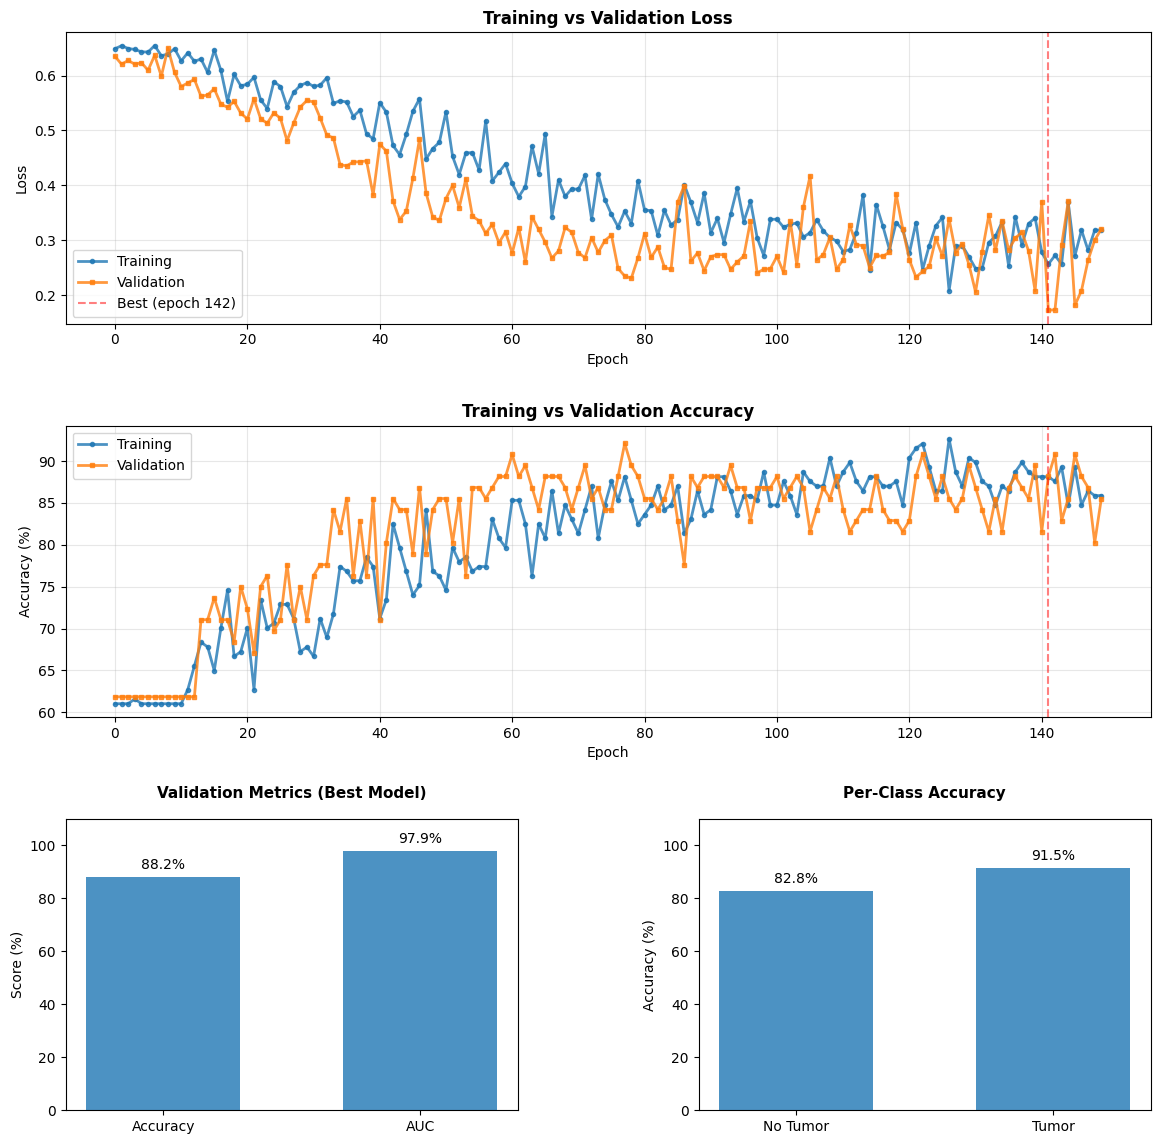


Final Results (Best Model from Epoch 142):
  Training accuracy: 88.14%
  Validation accuracy: 88.16%
  AUC score: 0.979

Performance Metrics:
  Total training time: 3.50 minutes
  Average epoch time: 1.40 seconds
  Evaluation time: 0.19 seconds
  Max CPU memory: 560.42 MB
  Max GPU memory: 576.61 MB

✅ Results saved to results_functional.csv


In [7]:
# Visualize Results

def create_visualizations(result: TrainingResult, eval_results: EvalResult, 
                          config: Config) -> plt.Figure:
    """
    Pure function: Create figure from immutable data.
    Returns figure object (side effect of display is at boundary).
    """
    # Extract history (immutable)
    train_losses = tuple(m.train_loss for m in result.history)
    train_accs = tuple(m.train_acc for m in result.history)
    val_losses = tuple(m.val_loss for m in result.history)
    val_accs = tuple(m.val_acc for m in result.history)
    best_epoch = result.final_state.best_epoch

    # Create figure
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 2], hspace=0.35, wspace=0.4)

    # Training and validation loss (top)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(train_losses, marker='o', linewidth=2, markersize=3, label='Training', alpha=0.8)
    ax1.plot(val_losses, marker='s', linewidth=2, markersize=3, label='Validation', alpha=0.8)
    ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f"Best (epoch {best_epoch+1})")
    ax1.set_title('Training vs Validation Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Training and validation accuracy (middle)
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(train_accs, marker='o', linewidth=2, markersize=3, label='Training', alpha=0.8)
    ax2.plot(val_accs, marker='s', linewidth=2, markersize=3, label='Validation', alpha=0.8)
    ax2.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Training vs Validation Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Validation metrics (bottom left)
    ax3 = fig.add_subplot(gs[2, 0])
    metrics_names = ('Accuracy', 'AUC')
    metrics_values = (eval_results.accuracy, eval_results.auc_score * 100)
    ax3.bar(metrics_names, metrics_values, alpha=0.8, width=0.6)
    ax3.set_title('Validation Metrics (Best Model)', fontsize=11, fontweight='bold', pad=15)
    ax3.set_ylabel('Score (%)', fontsize=10)
    ax3.set_ylim([0, 110])
    for i, v in enumerate(metrics_values):
        ax3.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

    # Per-class accuracy (bottom right)
    ax4 = fig.add_subplot(gs[2, 1])
    class_accuracies = tuple(
        100 * eval_results.class_correct[i] / eval_results.class_total[i] 
        if eval_results.class_total[i] > 0 else 0 
        for i in range(len(config.class_names))
    )
    ax4.bar(config.class_names, class_accuracies, alpha=0.8, width=0.6)
    ax4.set_title('Per-Class Accuracy', fontsize=11, fontweight='bold', pad=15)
    ax4.set_ylabel('Accuracy (%)', fontsize=10)
    ax4.set_ylim([0, 110])
    for i, v in enumerate(class_accuracies):
        ax4.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    return fig

def print_final_summary(result: TrainingResult, eval_results: EvalResult) -> None:
    """Side effect function: Print final summary (isolated at boundary)."""
    best_epoch = result.final_state.best_epoch
    train_accs = tuple(m.train_acc for m in result.history)
    val_accs = tuple(m.val_acc for m in result.history)
    train_losses = tuple(m.train_loss for m in result.history)
    val_losses = tuple(m.val_loss for m in result.history)
    
    print(f"\n{'='*60}")
    print(f"Final Results (Best Model from Epoch {best_epoch+1}):")
    print(f"{'='*60}")
    print(f"  Training accuracy: {train_accs[best_epoch]:.2f}%")
    print(f"  Validation accuracy: {val_accs[best_epoch]:.2f}%")
    print(f"  AUC score: {eval_results.auc_score:.3f}")
    print(f"\nPerformance Metrics:")
    print(f"  Total training time: {result.total_time/60:.2f} minutes")
    print(f"  Average epoch time: {result.avg_epoch_time:.2f} seconds")
    print(f"  Evaluation time: {eval_results.eval_time:.2f} seconds")
    print(f"  Max CPU memory: {result.max_cpu_memory:.2f} MB")
    print(f"  Max GPU memory: {result.max_gpu_memory:.2f} MB")
    print(f"{'='*60}")

# Create visualizations (pure function returns figure)
fig = create_visualizations(result, eval_results, CONFIG)

# Display figure (side effect)
plt.show()

# Print summary (side effect)
print_final_summary(result, eval_results)

# Save results to CSV (side effect at boundary)
import csv
from datetime import datetime

results_file = Path("results_functional.csv")
file_exists = results_file.exists()

with open(results_file, 'a', newline='') as f:
    writer = csv.writer(f)
    
    # Write header if file is new
    if not file_exists:
        writer.writerow([
            'timestamp', 'notebook', 'best_epoch', 
            'train_accuracy', 'val_accuracy', 'auc_score',
            'train_loss', 'val_loss',
            'total_time_minutes', 'avg_epoch_time_seconds',
            'max_cpu_memory_mb', 'max_gpu_memory_mb', 'eval_time_seconds'
        ])
    
    # Extract best epoch metrics
    best_epoch = result.final_state.best_epoch
    train_accs = tuple(m.train_acc for m in result.history)
    val_accs = tuple(m.val_acc for m in result.history)
    train_losses = tuple(m.train_loss for m in result.history)
    val_losses = tuple(m.val_loss for m in result.history)
    
    # Write results
    writer.writerow([
        datetime.now().isoformat(),
        'functional.ipynb',
        best_epoch + 1,
        train_accs[best_epoch],
        val_accs[best_epoch],
        eval_results.auc_score,
        train_losses[best_epoch],
        val_losses[best_epoch],
        result.total_time / 60,
        result.avg_epoch_time,
        result.max_cpu_memory,
        result.max_gpu_memory,
        eval_results.eval_time
    ])

print(f"\n✅ Results saved to {results_file}")
